# Data Structure

In the sequel, we shall use **StencilMatrix** and **StencilVector** from the **linalg.py** file.

For the moment, we are only interested about having an appropriate data structure to store our computations.
Once the assembly is done, we will convert the matrix into a scipy sparse matrix, while the vector will be converted to numpy array.

We will see later how one can impose boundary conditions.

# 1D Case

In [2]:
from spaces import SplineSpace

In [3]:
from linalg import StencilMatrix, StencilVector

In [4]:
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffness(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_x) * wvol

                matrix[i1, j1-i1]  += v
    # ...

    return matrix    
# ...

In [5]:
# ... Assembly procedure for the rhs
def assemble_rhs(f, nelements, degree, spans, basis, weights, points, rhs):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build rhs
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            i1 = i_span_1 - p1 + il_1

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis_1[ie1, il_1, 0, g1]
                bi_x = basis_1[ie1, il_1, 1, g1]  

                x1    = points_1[ie1, g1]
                wvol  = weights_1[ie1, g1]

                v += bi_0 * f(x1) * wvol

            rhs[i1] += v
    # ...

    # ...
    return rhs
    # ...
# ...

In [6]:
V = SplineSpace(degree=3, nelements=32)

In [7]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)

In [8]:
stiffness = assemble_stiffness(V.nelements, 
                               V.degree, 
                               V.spans, 
                               V.basis, 
                               V.weights, 
                               V.points, 
                               matrix=stiffness)

In [9]:
stiffness = stiffness.tosparse()

In [10]:
f = lambda x: 2.    

In [11]:
rhs = StencilVector(V.vector_space)

In [12]:
rhs = assemble_rhs(f, 
                   V.nelements, 
                   V.degree, 
                   V.spans, 
                   V.basis, 
                   V.weights, 
                   V.points, 
                   rhs=rhs)

In [13]:
rhs = rhs.toarray()

## 2D Case

In [14]:
from spaces import TensorSpace

In [15]:
V1 = SplineSpace(degree=2, nelements=16)
V2 = SplineSpace(degree=2, nelements=16)

V = TensorSpace(V1, V2)

In [16]:
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffness(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]        
            # evaluation dependant uniquement de l'element
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):                
                    for jl_1 in range(0, p1+1):
                        for jl_2 in range(0, p2+1):
                            i1 = i_span_1 - p1 + il_1
                            j1 = i_span_1 - p1 + jl_1

                            i2 = i_span_2 - p2 + il_2
                            j2 = i_span_2 - p2 + jl_2

                            v = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]

                                    bj_0 = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_x = basis_1[ie1, jl_1, 1, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_y = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 1, g2]

                                    wvol = weights_1[ie1, g1] * weights_2[ie2, g2]

                                    v += (bi_x * bj_x + bi_y * bj_y) * wvol

                            matrix[i1, i2, j1-i1, j2-i2]  += v
    # ...

    return matrix    
# ...

In [17]:
# ... Assembly procedure for the rhs
def assemble_rhs(f, nelements, degree, spans, basis, weights, points, rhs):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...

    # ... build rhs
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]                        
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):   
                    i1 = i_span_1 - p1 + il_1
                    i2 = i_span_2 - p2 + il_2                    

                    v = 0.0
                    for g1 in range(0, k1):
                        for g2 in range(0, k2):
                            bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]
                            
                            x1    = points_1[ie1, g1]
                            x2    = points_2[ie2, g2]
                            wvol  = weights_1[ie1, g1]*weights_2[ie2, g2]

                            v += bi_0 * f(x1,x2) * wvol

                    rhs[i1,i2] += v
    # ...

    # ...
    return rhs
    # ...
# ...

In [18]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)

In [19]:
stiffness = assemble_stiffness(V.nelements, 
                               V.degree, 
                               V.spans, 
                               V.basis, 
                               V.weights, 
                               V.points, 
                               matrix=stiffness)

In [20]:
stiffness = stiffness.tosparse()

In [21]:
# convert the sparse matrix to dense
stiffness = stiffness.toarray()

In [22]:
f = lambda x,y: 2.    

In [23]:
rhs = StencilVector(V.vector_space)

In [24]:
rhs = assemble_rhs(f, 
                   V.nelements, 
                   V.degree, 
                   V.spans, 
                   V.basis, 
                   V.weights, 
                   V.points, 
                   rhs=rhs)

### Matrix profile

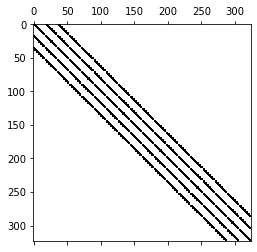

In [25]:
import matplotlib.pyplot as plt 

plt.spy(stiffness)